# Generate Adversarial Image for LeNet for MNIST dataset

In this notebook, I firstly define and train the LeNet with Tensorflow following the tutorial on [tensorflow.org](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html#deep-mnist-for-experts)

Then, conducted experiments in three parts
- Experiment on the `fast gradient sign` method descirbed in paper "Explaining and Harnessing Adversarial Examples" to fool the model, Part1
- To generate adversarial images to a target label, using gradient descent to update the input image, Part2
- Add L2 regularization term to the gradient descent method in Part2, and also compare their results, Part3

In [93]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Define and train the LeNet with Tensorflow follow the tutorial on [tensorflow.org](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html#deep-mnist-for-experts)

In [94]:
# Load data and create session
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.InteractiveSession(config=config)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [95]:
# placeholder for input
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [96]:
# Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


# Convolution and Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [97]:
# Build the LeNet neural network

# input layer
x_image = tf.reshape(x, [-1,28,28,1])

# first conv layer and pooling layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second conv layer and pooling layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# first fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


In [98]:
# Train and Evaluate the Model
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(10000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.08
step 1000, training accuracy 0.96
step 2000, training accuracy 0.98
step 3000, training accuracy 0.98
step 4000, training accuracy 0.98
step 5000, training accuracy 1
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 0.98
test accuracy 0.9899


In [109]:
# save model
saver = tf.train.Saver()
save_path = saver.save(sess, "./model.ckpt")

In [110]:
# Define commonly used variable for later use
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
prob = tf.nn.softmax(y_conv)

# the gradient w.r.t the input image
dx = tf.gradients(cross_entropy, x)

Define a set of helper function to get image, plot image, and get their predictions and probabilites

In [111]:
# randomly select one image from the test image with label of 2

def get_random_img_of_2():
    mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
    idx_of_img_2 = [mnist.test.cls == 2]
    img_with_label_2 = mnist.test.images[idx_of_img_2]
    idx = np.random.randint(len(img_with_label_2))
    return img_with_label_2[idx]


# plot the original image, the difference and the adversalry image
def plot_images(images, labels = ["Original Image", 
                                  "Difference", "Adversarial Image"]): 
    fig, axes = plt.subplots(1, 3)
    img_shape = (28, 28)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        ax.set_xlabel(labels[i])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
# Get prediction of input img from current model, output is the class number and its probability
def get_prediction(img):
    feed_dict = {x: [img], keep_prob: 1.0}
    prob = tf.nn.softmax(y_conv)
    res = prob.eval(feed_dict=feed_dict)
    return np.argmax(res), np.max(res)   


## 1. Using fast gradient sign method to fool the model

Follow the formula - fast gradient sign method - in the paper https://arxiv.org/pdf/1412.6572v3.pdf.

use the gradient of cross-entropy w.r.t to the input image to fool the model

In this way, the model will be fooled and predict a random label other than the correct one.

There is a magnitude parameter in the fast gradient sign method. 

-> Iteratively increase this parameter till the predicted labeled changed.

1/255 was chosed as step size because for 8 bit image, any change less than 1/255 will not make difference

2 0.999998
2 0.999997
2 0.999993
2 0.999987
2 0.999974
2 0.99995
2 0.999894
2 0.999837
2 0.999731
2 0.999452
2 0.998891
2 0.998269
2 0.997714
2 0.995761
2 0.993975
2 0.992114
2 0.989155
2 0.97858
2 0.963576
2 0.972387
2 0.965608
2 0.923037
2 0.940283
2 0.889097
2 0.906072
2 0.897105
2 0.76452
2 0.911012
2 0.796005
2 0.719974
2 0.716873
2 0.828416
2 0.612855
1 0.499209
1 0.572686
2 0.532115
1 0.626806
Predication is 1 after 37 iterations


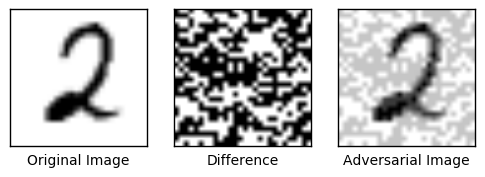

Prediction of original Image:  (2, 0.99999845)
Prediction of adversarial Image:  (1, 0.80266833)


In [112]:
# fast gradient sign method

def gen_adversarial_with_grad_sign(img, label, thres = 0.7):
    target_label = np.zeros((10, ));
    target_label[label] = 1.0
    feed_dict = {x: [img], y_: [target_label] ,keep_prob: 1.0}
    grad = sess.run(dx, feed_dict=feed_dict)
    grad_sign = np.sign(grad[0][0])
    
    for i in range(255):
        img_adv = img + i * (1.0/255) * grad_sign
        feed_dict = {x: [img_adv], y_: [target_label] ,keep_prob: 1.0}
        grad = sess.run(dx, feed_dict=feed_dict)
        grad_sign = np.sign(grad[0][0])
        
        pred, prob = get_prediction(img_adv)
        if pred != label and prob > thres:
            print "Predication is %d after %d iterations" % (pred, i)
            break
        print pred, prob
    return img_adv

def test_and_plot_adv1():
    test_img = get_random_img_of_2()
    img_adv = gen_adversarial_with_grad_sign(test_img, 2)
    imgs = [test_img, img_adv - test_img, img_adv]

    plot_images(imgs)
    print "Prediction of original Image: ", get_prediction(test_img)
    print "Prediction of adversarial Image: ", get_prediction(img_adv)
    
test_and_plot_adv1()

## 2. Using gradient descent to update image

 Generate adversarial image with target label, the basic idea is to update image to get the target label. 
 
-> It is an optimziation problem that $$img_{adv} = \arg\min_{img_{adv}} L(img, y, w) $$  
 where $y$ is the target label, $w$ is the model, $L$ is the cross-entropy loss of convnet, we need to find $img_{adv}$ starting from the input $img$

-> can be solved iteratively by gradient descent optimization

where in each backpropagation step the gradient w.r.t input $img$
 reflects the direction we want to change the input image (to output the target label).
 

In [113]:
def gen_adversarial_img(img, target, step_size = 0.005, thres = 0.7):
    '''
     Generate adversarial image with target label, 
     the basic idea is to update image instead of the gradient.
     We also need to change to grand truth label to target label 
     so that in backpropagation step the gradient
     reflects the direction we want to change (to the target label).
    '''
    '''Step size can be chosen by 1/(255*mean(abs(grad[0][0]))), 
        beacuse any change less than 1/255 will not make difference '''
    
    img_adv = img.copy()
    target_label = np.zeros((10, ));
    target_label[target] = 1.0
    feed_dict = {x: [img_adv],
            y_: [target_label],
            keep_prob: 1.0}
 
    while True:
        grad = sess.run(dx, feed_dict=feed_dict)
        img_adv -= step_size * grad[0][0]
        pred, prob = get_prediction(img_adv)
        if pred == target and prob > thres:
            break
                 
    return img_adv


def test_and_plot_adv2():
    test_img = get_random_img_of_2()
    img_adv = gen_adversarial_img(test_img, 6)
    imgs = [test_img, img_adv - test_img, img_adv]

    plot_images(imgs)
    print "Prediction of original Image: ", get_prediction(test_img)
    print "Prediction of adversarial Image: ", get_prediction(img_adv)

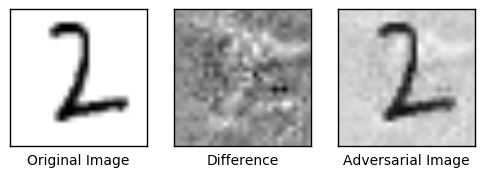

Prediction of original Image:  (2, 0.99998283)
Prediction of adversarial Image:  (6, 0.70307839)


In [114]:
test_and_plot_adv2()

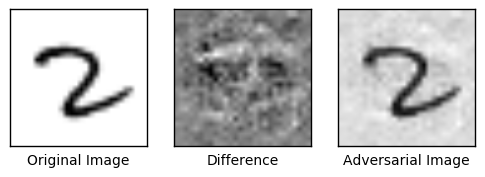

Prediction of original Image:  (2, 0.99985147)
Prediction of adversarial Image:  (6, 0.70036834)


In [115]:
test_and_plot_adv2()

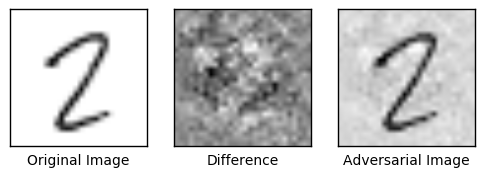

Prediction of original Image:  (2, 0.99263966)
Prediction of adversarial Image:  (6, 0.70422578)


In [116]:
test_and_plot_adv2()

## 3.  Add regularization term in loss and use gradient descent to update the input image

-> we can also add a L2 regularization term $\frac\lambda2 \|img_{adv} - img\|^2$ in the loss function to penalize the difference between $img$ and $img_{adv}$

just add the derivative of this regulariation term w.r.t img to dX to update in each iteration


In [127]:
def gen_adversarial_img_with_reg(img, target, step_size = 0.005, reg = 0.01, thres = 0.7):
    '''
     add the regluarization term in the loss function
     basically add the derivative of L2 regularization term which is reg * abs(img_adv - img) 
     to the convnet gradient dX w.r.t input img (the cross-entropy term in loss)
    '''
    
    img_adv = img.copy()
    target_label = np.zeros((10, ))
    target_label[target] = 1.0
    feed_dict = {x: [img_adv],
            y_: [target_label],
            keep_prob: 1.0}
    pred, prob = get_prediction(img_adv)
    while True:
        grad = sess.run(dx, feed_dict=feed_dict)
        img_adv -= step_size * (grad[0][0] + reg*(img_adv - img))
        pred, prob = get_prediction(img_adv)
        if pred == target and prob > thres:
            break
        
    return img_adv


def test_and_plot_adv3():
    test_img = get_random_img_of_2()
    img_adv = gen_adversarial_img_with_reg(test_img, 6)
    imgs = [test_img, img_adv - test_img, img_adv]

    plot_images(imgs)
    print "Prediction of original Image: ", get_prediction(test_img)
    print "Prediction of adversarial Image: ", get_prediction(img_adv)
    

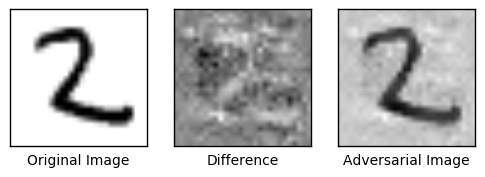

Prediction of original Image:  (2, 1.0)
Prediction of adversarial Image:  (6, 0.70773232)


In [128]:
test_and_plot_adv3()

In [129]:
def compare_adv2_and_adv3():
    '''
    compare the adversarial image generated with vs. without regularization term
    '''
    test_img = get_random_img_of_2()
    img_adv2 = gen_adversarial_img(test_img, 6)
    img_adv3 = gen_adversarial_img_with_reg(test_img, 6)
    imgs2 = [test_img, img_adv2 - test_img, img_adv2]
    imgs3 = [test_img, img_adv3 - test_img, img_adv3]
    
    print "Results without regularization, mean difference is %f" % np.mean((img_adv2 - test_img)**2)
    plot_images(imgs2)
    print "Prediction of original Image: ", get_prediction(test_img)
    print "Prediction of adversarial Image: ", get_prediction(img_adv2)
    
    print "\n\n"
    print "Results with regularization, mean difference is %f" % np.mean((img_adv3 - test_img)**2)
    plot_images(imgs3)
    print "Prediction of original Image: ", get_prediction(test_img)
    print "Prediction of adversarial Image: ", get_prediction(img_adv3)
   

Mean difference between adversarial image and original image is smaller, when optimized with L2 regularization

Results without regularization, mean difference is 0.007055


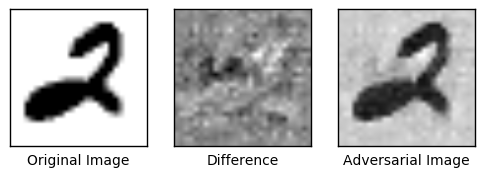

Prediction of original Image:  (2, 1.0)
Prediction of adversarial Image:  (6, 0.71120083)



Results with regularization, mean difference is 0.007045


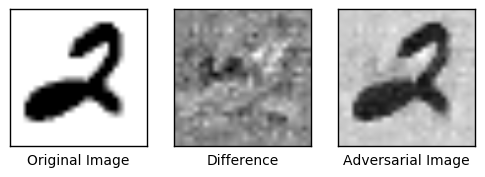

Prediction of original Image:  (2, 1.0)
Prediction of adversarial Image:  (6, 0.70929992)


In [130]:
compare_adv2_and_adv3()